Testing the difference between differend algorithms

In [55]:
PATH_PREFIX = '../../'
import sys
sys.path.append(PATH_PREFIX)

In [56]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import math
import yaml
from utils.plot import *
from utils.fitness_controller import FitnessController
from compress_optim import CompressConfig, load_comp_config, fit_from_vals

Visualization settings

In [57]:
BASE_PATH = os.path.join(PATH_PREFIX, 'results/lenet_tanh_compress_50_locked/')
SAVE_FILES = {
    'lenet_RND_save.csv': 'RND',
    'lenet_PSO_save.csv': 'PSO',
    'lenet_GA_save.csv': 'GA',
    'lenet_BH_save.csv': 'BH',
}

SAVE_PLOTS = False
SAVE_PLOTS_LOC = os.path.join(PATH_PREFIX, 'results/plots/')
SAVE_PLOT_ID = 1
ACC_TRESHOLD = 0.01


Data loaded from experiment settings

In [58]:
cf = None

with open(os.path.join(BASE_PATH, 'experiment_setting.yaml'), 'r') as config:
    load_comp_config(yaml.safe_load(config))

Loaded data structures

In [59]:
data = {
    'run': [],
}

data_complete = {
    'run': [],
    'accuracy': [],
    'accuracy_loss': [],
    'compression': [],
    'type': [],
}

# all dirs with the experiment data
exp_dirs = [name for name in os.listdir(BASE_PATH) if os.path.isdir(os.path.join(BASE_PATH, name))]

Getting correct fitness controler target value by observing all the data

In [60]:
global_fit_cont = FitnessController(CompressConfig.OPTIM_TARGET, None, fit_from_vals, target_update_offset=CompressConfig.OPTIM_TARGET_UPDATE_OFFSET, 
            target_limit=CompressConfig.OPTIM_TARGET_LOW_LIMIT, lock=CompressConfig.OPTIM_TARGET_LOCK)

for dir in exp_dirs:
    for file in os.listdir(os.path.join(BASE_PATH, dir)):

        save_df = pd.read_csv(os.path.join(BASE_PATH, dir, file))
        global_fit_cont.fit_from_df(save_df, verbose=True)

print(global_fit_cont.targ)


[ 0.99 18.  ]


Get data for boxplots

In [61]:
for dir in exp_dirs:

    data['run'].append(dir)

    for file in os.listdir(os.path.join(BASE_PATH, dir)):
        
        # loading the data
        save_df = pd.read_csv(os.path.join(BASE_PATH, dir, file))

        loc_fit_cont = FitnessController(CompressConfig.OPTIM_TARGET, None, fit_from_vals, target_update_offset=CompressConfig.OPTIM_TARGET_UPDATE_OFFSET, 
            target_limit=CompressConfig.OPTIM_TARGET_LOW_LIMIT, lock=CompressConfig.OPTIM_TARGET_LOCK)

        # get correct fitness row by current fitness controller
        loc_fit_cont.fit_from_df(save_df, verbose=True)

        # saving best found row
        data_row = (save_df[save_df['fitness'] == save_df['fitness'].max()]).iloc[0]

        key = SAVE_FILES[file]

        if key not in data.keys():
            data[key] = []
        
        data_complete['run'].append(dir)
        data_complete['accuracy'].append(data_row['accuracy'])
        data_complete['accuracy_loss'].append(data_row['accuracy_loss'])
        data_complete['compression'].append(data_row['compression'])
        data_complete['type'].append(key)

        data[key].append(data_row['fitness'])

data = pd.DataFrame(data)
data_complete = pd.DataFrame(data_complete)
global_fit_cont.fit_from_df(data_complete)
data

,run,GA,RND,PSO,BH
0,run7,8.019245,7.188244,11.398622,23.876653
1,run3,44.582343,7.641139,61.993352,60.192296
2,run4,9.531471,3.759180,63.965002,105.289576
3,run10,51.025426,5.529948,91.544789,58.934955
4,run2,52.404299,12.042956,42.893950,72.440192
5,run8,50.540263,6.276601,22.838599,34.221707
6,run9,99.551022,4.626455,61.993352,12.312528
7,run11,94.061930,3.676912,91.544789,5.708805
8,run1,59.896352,8.832804,63.434854,51.862445
9,run5,93.296354,5.495245,61.047166,42.961242


Optimization comparsion boxplot graph

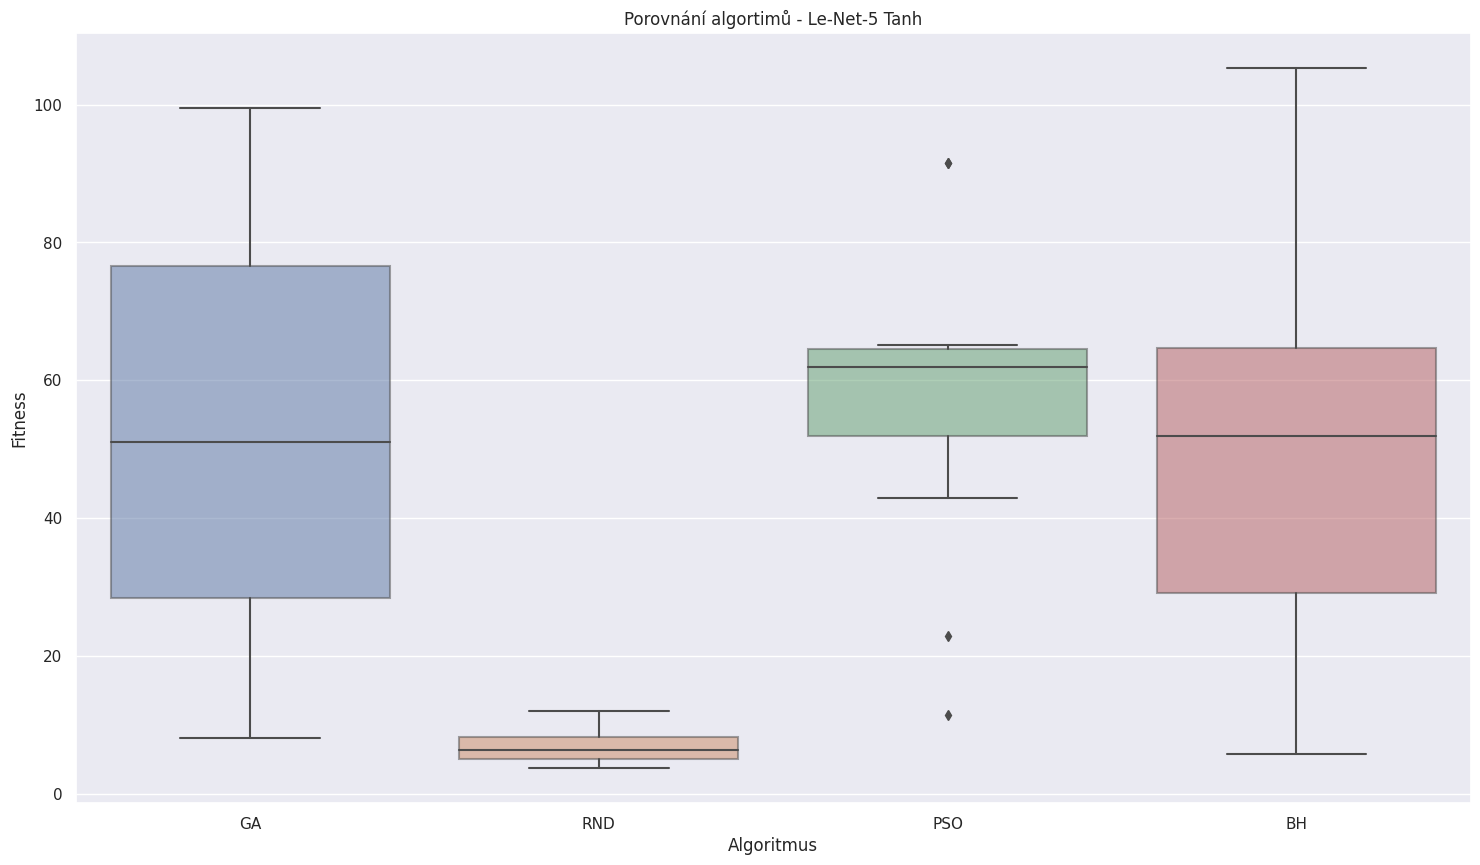

In [62]:
sns.set(style="darkgrid")
graph = sns.boxplot(data=data_complete, x='type', y='fitness', boxprops=dict(alpha=0.5)) #  medianprops={"color": "coral"}
graph.set(xlabel = 'Algoritmus', ylabel='Fitness', title='Porovnání algortimů - Le-Net-5 Tanh')

if SAVE_PLOTS:
    graph.get_figure().savefig(os.path.join(SAVE_PLOTS_LOC, f'box{SAVE_PLOT_ID}.pdf'))

Optimization progress graph

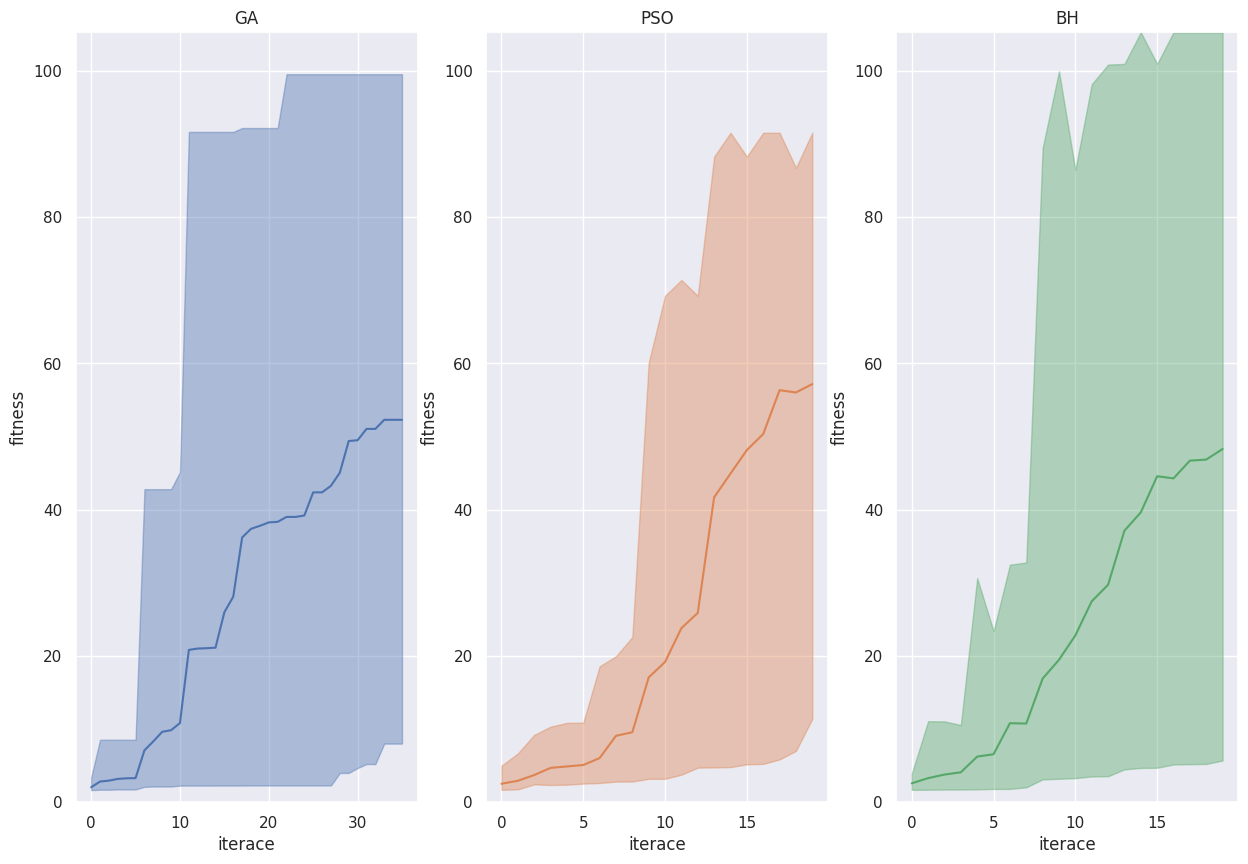

In [63]:
files = {
   # 'RND': [],
    'GA': [],
    'PSO': [],
    'BH': [],
}

for key in files.keys():
    for i in range(1, 12):
        files[key].append(f'{BASE_PATH}run{i}/lenet_{key}_save.csv')

plot_optimalization_progress(files, global_fit_cont)

if SAVE_PLOTS:
    plt.savefig(os.path.join(SAVE_PLOTS_LOC, f'line{SAVE_PLOT_ID}.pdf'))

Comparsion of optimization techiques

<AxesSubplot:xlabel='compression', ylabel='accuracy_loss'>

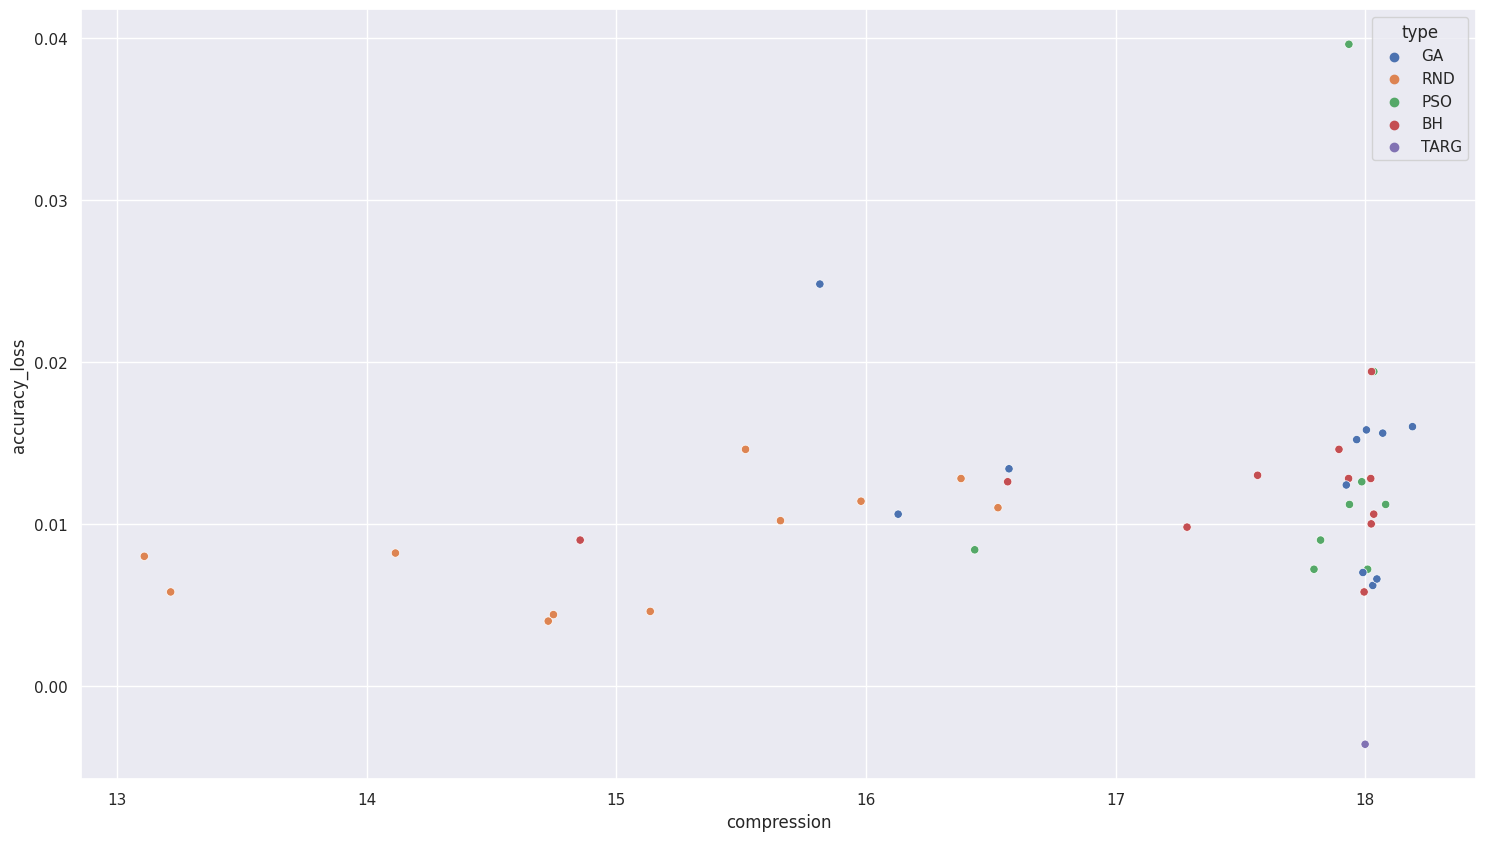

In [64]:
before_loss = data_complete.loc[0]['accuracy'] + data_complete.loc[0]['accuracy_loss'] 
data_complete.loc[len(data_complete.index)] = ['run0', global_fit_cont.targ[0], before_loss - global_fit_cont.targ[0], global_fit_cont.targ[1], 'TARG', 0]

sns.set(rc={'figure.figsize': (18, 10)})
sns.scatterplot(data=data_complete, x='compression', y='accuracy_loss', hue='type')

Showing performance graphs

In [65]:
plt_data = pd.read_csv(os.path.join(PATH_PREFIX, 'results/lenet_relu_compress_50_locked/run3/lenet_PSO_save.csv'))
plt_data

,time,position,representation,velocity,accuracy,accuracy_loss,compression,share_t,train_t,acc_t
0,0,"[0, 0, 2.8892227612916077, 0, 11.627579706248262]","[14, 19, 19, 43, 26]","[-0.4678228380064017, -0.14073748835532812, -2...",0.9850,-0.0004,5.435053,1.034429,0.0,0.540572
1,0,"[0, 0, 4.624798934741246, 0, 15.79669544840764]","[13, 10, 11, 21, 13]","[-0.6522780561279676, -0.11258999068426251, 0....",0.9826,0.0020,6.702707,0.732214,0.0,0.538928
2,0,"[0, 0, 5.215930825039122, 0, 12.002424559197431]","[27, 9, 43, 10, 41]","[-0.08350068080659612, -0.14073748835532812, -...",0.9824,0.0022,5.557930,1.393429,0.0,0.539438
3,0,"[0, 0, 2.8822502896929887, 0, 12.53742963483213]","[22, 41, 7, 44, 37]","[-0.740792063090834, -0.5368709120000003, -4, ...",0.9836,0.0010,5.578024,0.813345,0.0,0.525914
4,0,"[0.19093870931989965, 0, 4.5654703566222015, 0...","[49, 7, 44, 50, 9]","[-0.38438416156089894, -0.1145713100693868, -0...",0.9842,0.0004,5.964675,1.618200,0.0,0.537729
...,...,...,...,...,...,...,...,...,...,...
395,19,"[0, 0, 1.0444619914394675, 0, 6.813423120369908]","[2, 4, 5, 3, 10]","[-0.09383974915459774, -0.14073748835532812, -...",0.9642,0.0204,14.316072,0.329884,0.0,0.538359
396,19,"[0, 0, 4.5268933710309645, 0, 13.438666620794528]","[2, 4, 8, 3, 17]","[-0.2899495008820396, -0.11339961261516181, -0...",0.9676,0.0170,13.982635,0.434937,0.0,0.536944
397,19,"[0, 0, 2.2117797016489438, 0, 17.722608300186454]","[2, 4, 6, 3, 21]","[-0.20211522314573413, -0.3435973836800002, -0...",0.9672,0.0174,13.950563,0.426921,0.0,0.539369
398,19,"[0, 0, 5.628236795815805, 0, 17.90036101762363]","[2, 4, 9, 3, 21]","[-0.09580406016739257, -0.2157348796478209, 3....",0.9674,0.0172,13.417641,0.541235,0.0,0.539771


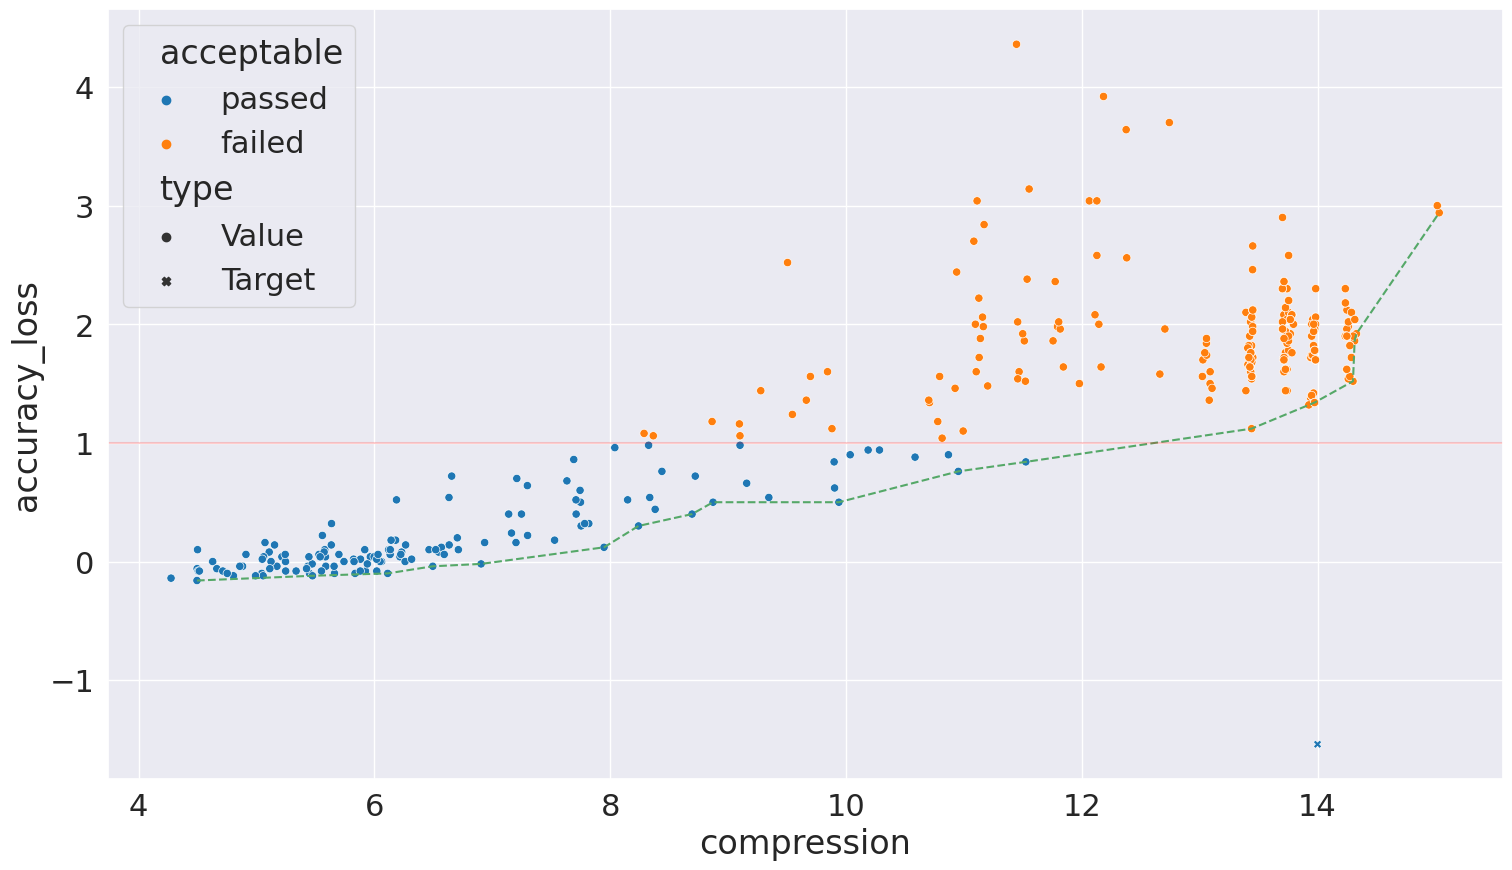

In [66]:
#plt_data = pd.read_csv('../results/lenet_tanh_compress_50/run10/lenet_PSO_save.csv')
#plt_data = pd.read_csv('../results/lenet_relu_compress_50/run8/lenet_PSO_save.csv')
#plt_data = pd.read_csv('../results/lenet_relu_compress_50/run9/lenet_GA_save.csv')

plot_alcr(plt_data, 0.01, [1.0, 14.0], True)
#plt.title('GA algoritmus - LeNet-5 ReLu')
#plt.xlabel('Komprese')
#plt.ylabel('Ztráta přesnosti [%]')

if SAVE_PLOTS:
    plt.savefig(os.path.join(SAVE_PLOTS_LOC, f'scatter{SAVE_PLOT_ID}.pdf'))

Compare two or more experiments (meant for dynamic and static target)

In [67]:
NET_TYPE = 'tanh'

FOLDERS_EXP = [
    {'path': os.path.join(PATH_PREFIX, f'results/lenet_{NET_TYPE}_compress_50_locked/'), 'type': 'static'}, 
    {'path': os.path.join(PATH_PREFIX, f'results/lenet_{NET_TYPE}_compress_50_extrem_dynamic/'), 'type': 'extreme dynamic'},
    {'path': os.path.join(PATH_PREFIX, f'results/lenet_{NET_TYPE}_compress_50_dynamic/'), 'type': 'dynamic'}
    ]

FILE_FILT_SHOW = [
    'lenet_GA_save.csv', 
    'lenet_PSO_save.csv',
    'lenet_BH_save.csv',
]

In [68]:
fit_conts:list[FitnessController] = []

data_complete = {
    'run': [],
    'accuracy': [],
    'accuracy_loss': [],
    'compression': [],
    'fitness':[],
    'type': [],
    'tar_type': [],
}

for experiment in FOLDERS_EXP:

    exp_dirs = [name for name in os.listdir(experiment['path']) if os.path.isdir(os.path.join(experiment['path'], name))]

    # load config
    with open(os.path.join(experiment['path'], 'experiment_setting.yaml'), 'r') as config:
        load_comp_config(yaml.safe_load(config))
    
    print(experiment['path'], CompressConfig.OPTIM_TARGET, CompressConfig.OPTIM_TARGET_LOCK)

    # update corresponding global fitness controller target
    fit_conts.append(FitnessController(CompressConfig.OPTIM_TARGET, None, fit_from_vals, target_update_offset=CompressConfig.OPTIM_TARGET_UPDATE_OFFSET, 
        target_limit=CompressConfig.OPTIM_TARGET_LOW_LIMIT, lock=CompressConfig.OPTIM_TARGET_LOCK))

    for dir in exp_dirs:

        for file in [x for x in os.listdir(os.path.join(experiment['path'], dir)) if x in FILE_FILT_SHOW]:

            save_df = pd.read_csv(os.path.join(experiment['path'], dir, file))
            
            fit_conts[-1].fit_from_df(save_df, verbose=True)

    print(fit_conts[-1].targ)

    for dir in exp_dirs:

        for file in [x for x in os.listdir(os.path.join(experiment['path'], dir)) if x in FILE_FILT_SHOW]:
            
            # loading the data
            save_df = pd.read_csv(os.path.join(experiment['path'], dir, file))

            save_df = save_df[save_df['accuracy_loss'] < ACC_TRESHOLD]

            # dropping fitness column if found
            if 'fitness' in save_df.columns:
                #old_fit[key].append(save_df['fitness'].max())
                save_df = save_df.drop('fitness', axis=1)

            with open(os.path.join(experiment['path'], 'experiment_setting.yaml'), 'r') as config:
                load_comp_config(yaml.safe_load(config))

            # update corresponding global fitness controller target
            local_fit = FitnessController(CompressConfig.OPTIM_TARGET, None, fit_from_vals, target_update_offset=CompressConfig.OPTIM_TARGET_UPDATE_OFFSET, 
                target_limit=CompressConfig.OPTIM_TARGET_LOW_LIMIT, lock=CompressConfig.OPTIM_TARGET_LOCK)

            # get correct fitness row by current fitness controller
            local_fit.fit_from_df(save_df, verbose=True)

            # saving best found row
            data_row = (save_df[save_df['fitness'] == save_df['fitness'].max()]).iloc[0]
            
            data_complete['run'].append(dir)
            data_complete['accuracy'].append(data_row['accuracy'])
            data_complete['accuracy_loss'].append(data_row['accuracy_loss'])
            data_complete['compression'].append(data_row['compression'])
            data_complete['fitness'].append(data_row['fitness'])
            data_complete['type'].append(SAVE_FILES[file])
            data_complete['tar_type'].append(experiment['type'])

data_complete = pd.DataFrame(data_complete)


../../results/lenet_tanh_compress_50_locked/ [0.99, 18.0] True
[ 0.99 18.  ]
../../results/lenet_tanh_compress_50_extrem_dynamic/ [0.01, 1.0] False
Fitness target update to [ 0.9882   21.828788]
Fitness target update to [ 0.9882   22.713583]
Fitness target update to [ 0.9894   22.713583]
[ 0.9894   22.713583]
Fitness target update to [ 0.9882   16.720386]
Fitness target update to [ 0.9882   17.385301]
Fitness target update to [ 0.9884   18.119592]
Fitness target update to [ 0.9882   16.737209]
Fitness target update to [ 0.9888   17.925788]
Fitness target update to [ 0.9882   15.795722]
Fitness target update to [ 0.988    17.591323]
Fitness target update to [ 0.9884   14.362591]
Fitness target update to [ 0.989    19.189684]
Fitness target update to [ 0.9882  18.97552]
Fitness target update to [ 0.9886   15.806818]
Fitness target update to [ 0.9882   14.410105]
Fitness target update to [ 0.9886   14.114096]
Fitness target update to [ 0.9894   17.585748]
Fitness target update to [ 0.9884

In [69]:
pareto_front = pareto_from_df(data_complete)

In [70]:
before_loss = data_complete.loc[0]['accuracy'] + data_complete.loc[0]['accuracy_loss']

for i, fit_cont in enumerate(fit_conts):
    data_complete.loc[len(data_complete.index)] = ['run0', fit_cont.targ[0], before_loss - fit_cont.targ[0], fit_cont.targ[1], 100, 'TARG', FOLDERS_EXP[i]['type']]

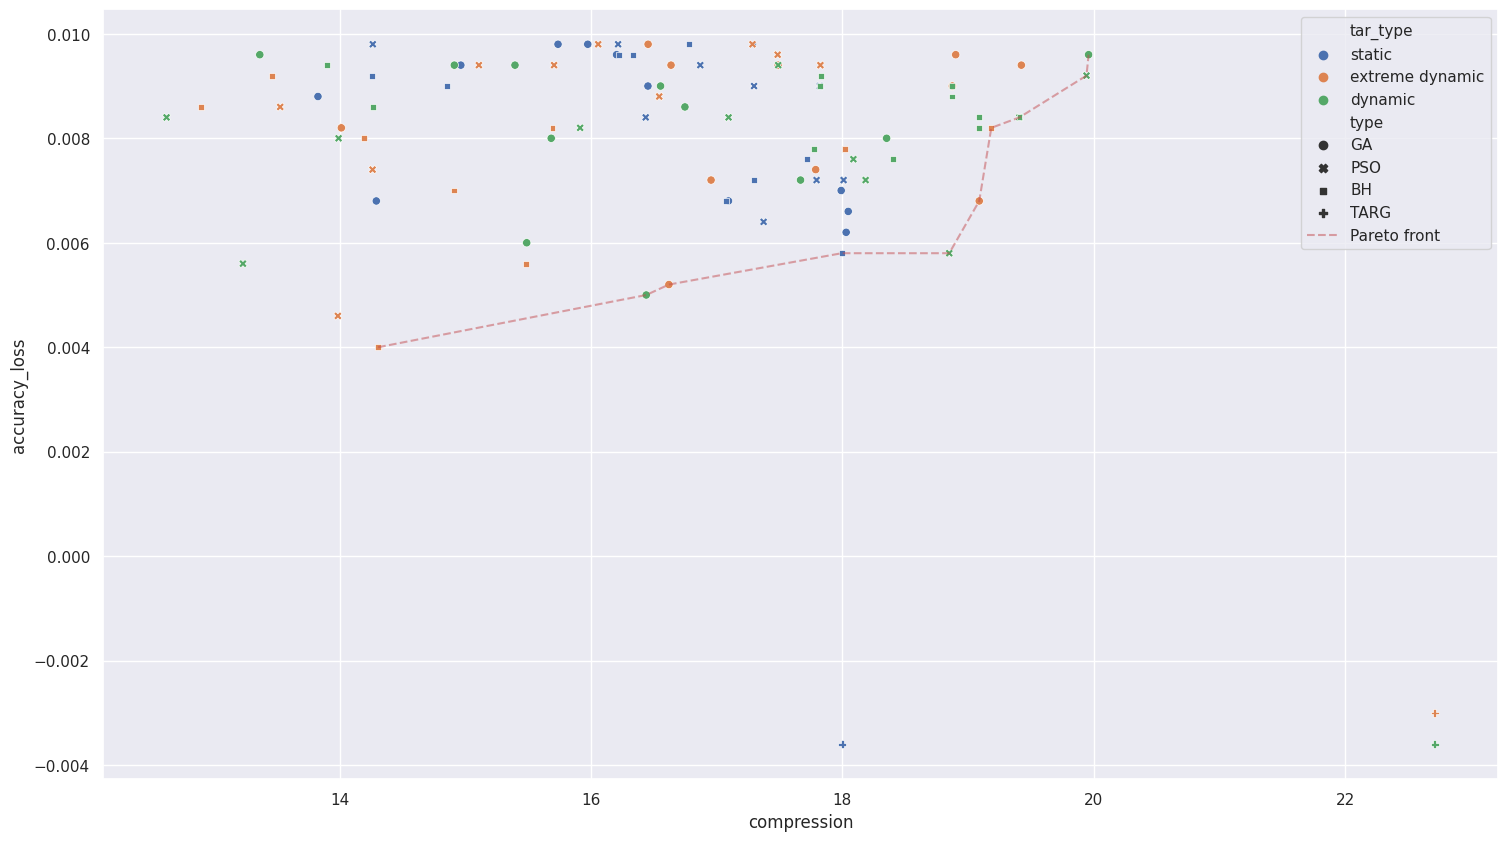

In [71]:
sns.set(rc={'figure.figsize': (18, 10)})
sns.scatterplot(data=data_complete, x='compression', y='accuracy_loss', style='type', hue='tar_type')

plt.plot(list(pareto_front['compression']), list(pareto_front['accuracy_loss']), 'r--', alpha=0.5, label='Pareto front')
plt.legend()

Diferend precision reduction types

In [72]:
NET_TYPE = 'tanh'

FOLDERS_EXP = [
    {'path': os.path.join(PATH_PREFIX, f'results/lenet_{NET_TYPE}_compress_50_extrem_dynamic/'), 'type': 'f4'},
    {'path': os.path.join(PATH_PREFIX, f'results/lenet_{NET_TYPE}_compress_50_dynamic_f2/'), 'type': 'f2'}, 
    {'path': os.path.join(PATH_PREFIX, f'results/lenet_{NET_TYPE}_compress_50_dynamic_f1/'), 'type': 'f1'}
    ]

FILE_FILT_SHOW = [
    'lenet_GA_save.csv', 
    'lenet_PSO_save.csv',
    'lenet_BH_save.csv',
]

In [73]:
fit_conts:list[FitnessController] = []

data_complete = {
    'run': [],
    'accuracy': [],
    'accuracy_loss': [],
    'compression': [],
    'fitness':[],
    'type': [],
    'tar_type': [],
}

for experiment in FOLDERS_EXP:

    exp_dirs = [name for name in os.listdir(experiment['path']) if os.path.isdir(os.path.join(experiment['path'], name))]

    # load config
    with open(os.path.join(experiment['path'], 'experiment_setting.yaml'), 'r') as config:
        load_comp_config(yaml.safe_load(config))
    
    print(experiment['path'], CompressConfig.OPTIM_TARGET, CompressConfig.OPTIM_TARGET_LOCK)

    # update corresponding global fitness controller target
    fit_conts.append(FitnessController(CompressConfig.OPTIM_TARGET, None, fit_from_vals, target_update_offset=CompressConfig.OPTIM_TARGET_UPDATE_OFFSET, 
        target_limit=CompressConfig.OPTIM_TARGET_LOW_LIMIT, lock=CompressConfig.OPTIM_TARGET_LOCK))

    for dir in exp_dirs:

        for file in [x for x in os.listdir(os.path.join(experiment['path'], dir)) if x in FILE_FILT_SHOW]:

            save_df = pd.read_csv(os.path.join(experiment['path'], dir, file))
            
            fit_conts[-1].fit_from_df(save_df, verbose=True)

    print(fit_conts[-1].targ)

    for dir in exp_dirs:

        for file in [x for x in os.listdir(os.path.join(experiment['path'], dir)) if x in FILE_FILT_SHOW]:
            
            # loading the data
            save_df = pd.read_csv(os.path.join(experiment['path'], dir, file))

            save_df = save_df[save_df['accuracy_loss'] < ACC_TRESHOLD]

            # dropping fitness column if found
            if 'fitness' in save_df.columns:
                #old_fit[key].append(save_df['fitness'].max())
                save_df = save_df.drop('fitness', axis=1)

            with open(os.path.join(experiment['path'], 'experiment_setting.yaml'), 'r') as config:
                load_comp_config(yaml.safe_load(config))

            # update corresponding global fitness controller target
            local_fit = FitnessController(CompressConfig.OPTIM_TARGET, None, fit_from_vals, target_update_offset=CompressConfig.OPTIM_TARGET_UPDATE_OFFSET, 
                target_limit=CompressConfig.OPTIM_TARGET_LOW_LIMIT, lock=CompressConfig.OPTIM_TARGET_LOCK)

            # get correct fitness row by current fitness controller
            local_fit.fit_from_df(save_df, verbose=True)

            # saving best found row
            data_row = (save_df[save_df['fitness'] == save_df['fitness'].max()]).iloc[0]
            
            data_complete['run'].append(dir)
            data_complete['accuracy'].append(data_row['accuracy'])
            data_complete['accuracy_loss'].append(data_row['accuracy_loss'])
            data_complete['compression'].append(data_row['compression'])
            data_complete['fitness'].append(data_row['fitness'])
            data_complete['type'].append(SAVE_FILES[file])
            data_complete['tar_type'].append(experiment['type'])

data_complete = pd.DataFrame(data_complete)


../../results/lenet_tanh_compress_50_extrem_dynamic/ [0.01, 1.0] False
Fitness target update to [ 0.9882   21.828788]
Fitness target update to [ 0.9882   22.713583]
Fitness target update to [ 0.9894   22.713583]
[ 0.9894   22.713583]
Fitness target update to [ 0.9882   16.720386]
Fitness target update to [ 0.9882   17.385301]
Fitness target update to [ 0.9884   18.119592]
Fitness target update to [ 0.9882   16.737209]
Fitness target update to [ 0.9888   17.925788]
Fitness target update to [ 0.9882   15.795722]
Fitness target update to [ 0.988    17.591323]
Fitness target update to [ 0.9884   14.362591]
Fitness target update to [ 0.989    19.189684]
Fitness target update to [ 0.9882  18.97552]
Fitness target update to [ 0.9886   15.806818]
Fitness target update to [ 0.9882   14.410105]
Fitness target update to [ 0.9886   14.114096]
Fitness target update to [ 0.9894   17.585748]
Fitness target update to [ 0.9884   19.285528]
Fitness target update to [ 0.9876   17.888239]
Fitness target u

In [74]:
pareto_front = pareto_from_df(data_complete)

In [75]:
before_loss = data_complete.loc[0]['accuracy'] + data_complete.loc[0]['accuracy_loss']

for i, fit_cont in enumerate(fit_conts):
    data_complete.loc[len(data_complete.index)] = ['run0', fit_cont.targ[0], before_loss - fit_cont.targ[0], fit_cont.targ[1], 100, 'TARG', FOLDERS_EXP[i]['type']]

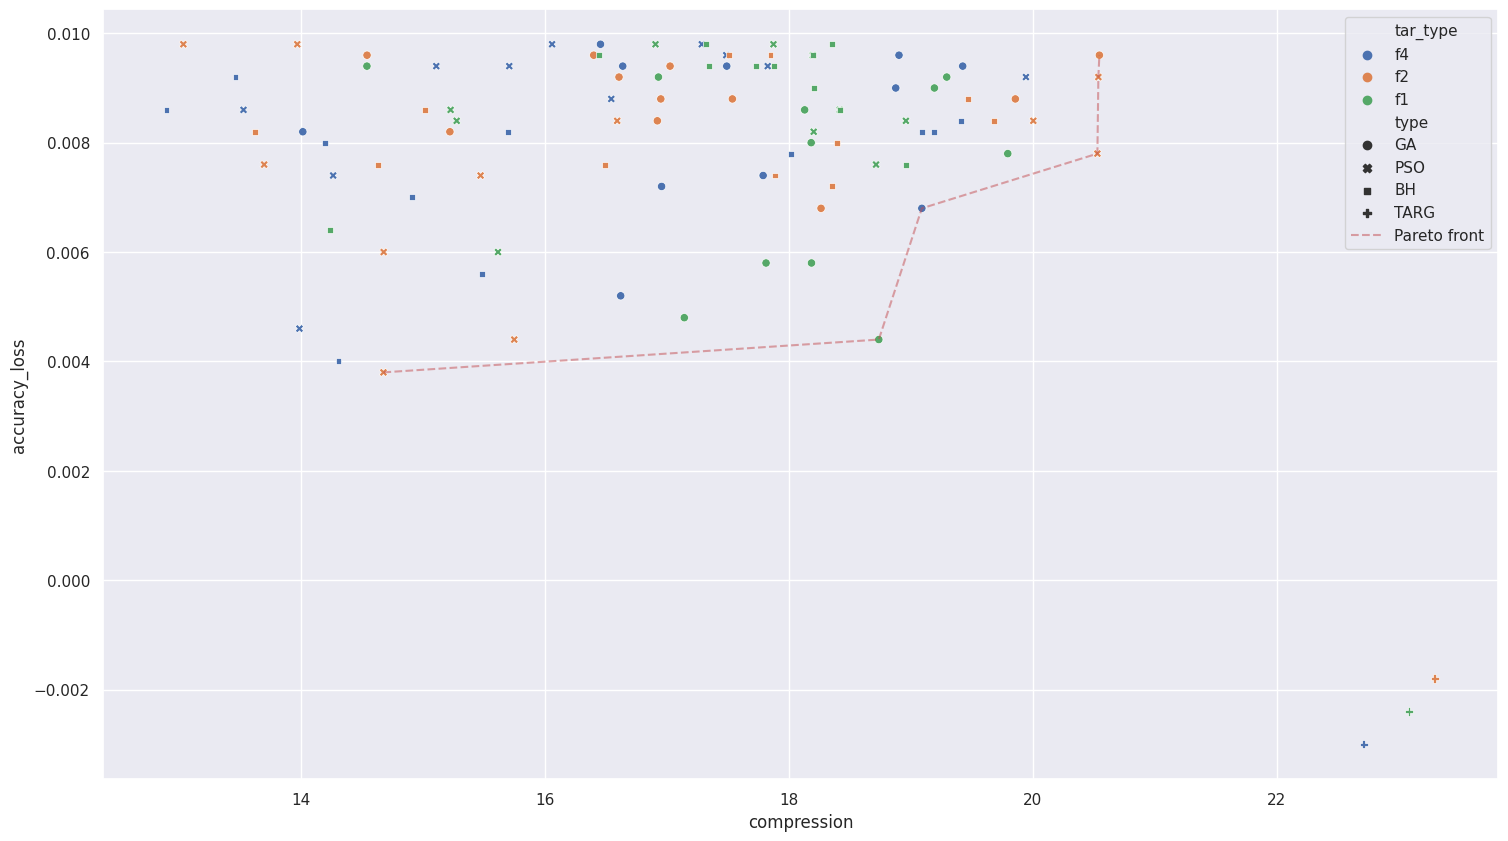

In [76]:
sns.set(rc={'figure.figsize': (18, 10)})
sns.scatterplot(data=data_complete, x='compression', y='accuracy_loss', style='type', hue='tar_type')

plt.plot(list(pareto_front['compression']), list(pareto_front['accuracy_loss']), 'r--', alpha=0.5, label='Pareto front')
plt.legend()

Comprate pareto lines of differend precision reduction types

In [77]:
NET_TYPE = 'relu'

FOLDERS_EXP = [
    {'path': os.path.join(PATH_PREFIX, f'results/lenet_{NET_TYPE}_compress_50_extrem_dynamic/'), 'type': 'f4'},
    {'path': os.path.join(PATH_PREFIX, f'results/lenet_{NET_TYPE}_compress_50_dynamic_f2/'), 'type': 'f2'}, 
    {'path': os.path.join(PATH_PREFIX, f'results/lenet_{NET_TYPE}_compress_50_dynamic_f1/'), 'type': 'f1'}
    ]

FILE_FILT_SHOW = [
    'lenet_GA_save.csv', 
    'lenet_PSO_save.csv',
    'lenet_BH_save.csv',
]

In [78]:
data_complete = {
    'accuracy': [],
    'accuracy_loss': [],
    'compression': [],
    'type': [],
    'tar_type': [],
}

for experiment in FOLDERS_EXP:

    exp_dirs = [name for name in os.listdir(experiment['path']) if os.path.isdir(os.path.join(experiment['path'], name))]

    # load config
    with open(os.path.join(experiment['path'], 'experiment_setting.yaml'), 'r') as config:
        load_comp_config(yaml.safe_load(config))
    
    print(experiment['path'])

    for dir in exp_dirs:

        for file in [x for x in os.listdir(os.path.join(experiment['path'], dir)) if x in FILE_FILT_SHOW]:
            
            # loading the data
            save_df = pd.read_csv(os.path.join(experiment['path'], dir, file))
            
            add_df = pareto_from_df(save_df[save_df['accuracy_loss'] < ACC_TRESHOLD])            

            data_complete['accuracy'] += list(add_df['accuracy'])
            data_complete['accuracy_loss'] += list(add_df['accuracy_loss'])
            data_complete['compression'] += list(add_df['compression'])
            data_complete['type'] += [SAVE_FILES[file] for _ in range(len(add_df.index))] 
            data_complete['tar_type'] += [experiment['type'] for _ in range(len(add_df.index))]
            
data_complete = pd.DataFrame(data_complete)


../../results/lenet_relu_compress_50_extrem_dynamic/
../../results/lenet_relu_compress_50_dynamic_f2/
../../results/lenet_relu_compress_50_dynamic_f1/


<AxesSubplot:xlabel='compression', ylabel='accuracy_loss'>

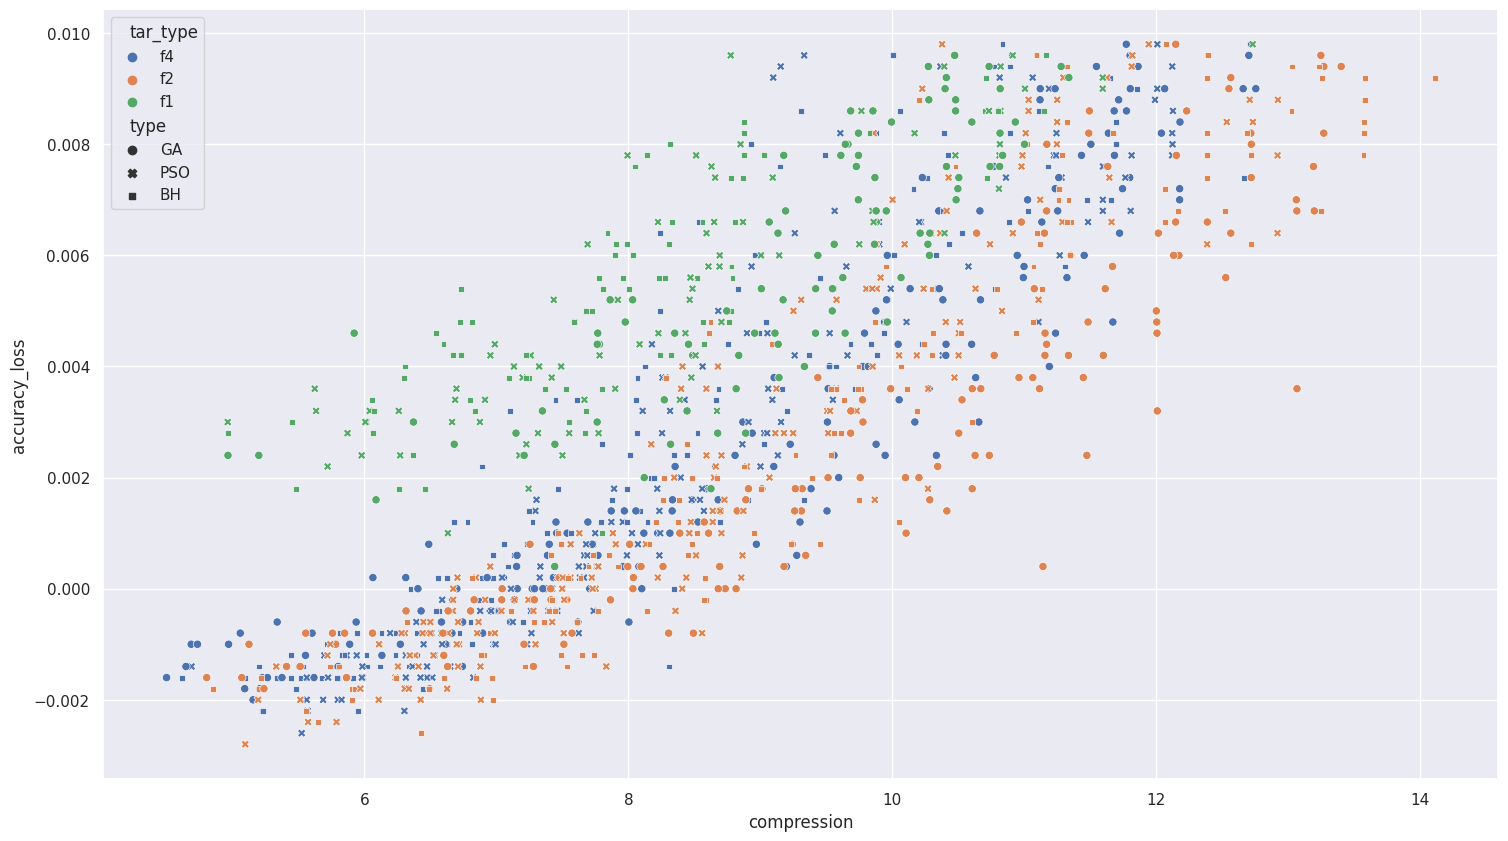

In [79]:
sns.scatterplot(data=data_complete, x='compression', y='accuracy_loss', style='type', hue='tar_type')

In [80]:
data_complete

,accuracy,accuracy_loss,compression,type,tar_type
0,0.9862,-0.0016,5.228719,GA,f4
1,0.9858,-0.0012,5.554155,GA,f4
2,0.9854,-0.0008,6.663545,GA,f4
3,0.9852,-0.0006,7.107124,GA,f4
4,0.9846,0.0000,7.374566,GA,f4
...,...,...,...,...,...
1198,0.9798,0.0048,7.588867,BH,f1
1199,0.9782,0.0064,7.841674,BH,f1
1200,0.9780,0.0066,8.561381,BH,f1
1201,0.9772,0.0074,8.776201,BH,f1


<AxesSubplot:xlabel='compression', ylabel='accuracy_loss'>

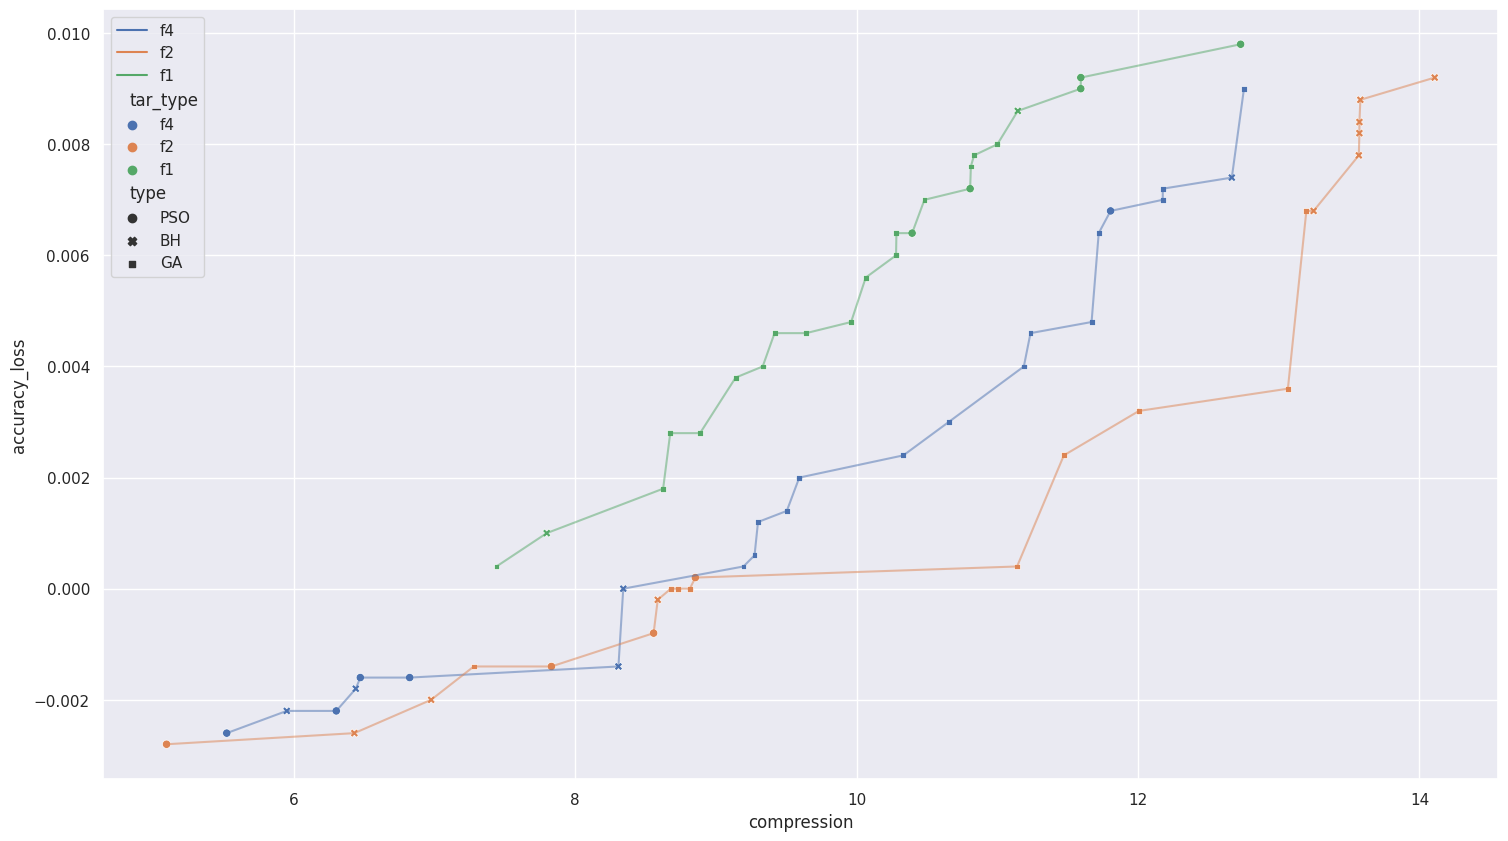

In [81]:
pareto_data = {
    'accuracy': [],
    'accuracy_loss': [],
    'compression': [],
    'type': [],
    'tar_type': [],
}

pareto_data = pd.DataFrame(pareto_data)

for prec_type in ['f4', 'f2', 'f1']:
    pareto_data = pareto_data.append(pareto_from_df(data_complete[data_complete['tar_type'] == prec_type]), ignore_index=True)

#sns.lmplot(data=pareto_data, x='compression', y='accuracy_loss', hue='tar_type', order=2, size=7, aspect=1.6)
sns.lineplot(data=pareto_data, x='compression', y='accuracy_loss', hue='tar_type', alpha=0.5)
sns.scatterplot(data=pareto_data, x='compression', y='accuracy_loss', style='type', hue='tar_type')
